In [25]:
import os
import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.externals import joblib
from sklearn import tree
from sklearn.metrics import roc_auc_score
from sklearn import metrics
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
try:
    from sklearn.model_selection import train_test_split
except:
    from sklearn.cross_validation import train_test_split
%matplotlib inline

sns.set(style="ticks", color_codes=True)


ibm_data = pd.read_csv("HR_IBM.csv")
xyz_data = pd.read_csv("organization.csv")
fields_to_drop = ['EmployeeCount', 'Over18', 'EmployeeNumber', 'StandardHours','DailyRate','HourlyRate','Education']

ibm_data.describe()

,Age,DailyRate,DistanceFromHome,Education,EmployeeCount,EmployeeNumber,EnvironmentSatisfaction,HourlyRate,JobInvolvement,JobLevel,...,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
count,6210.000000,6210.000000,6210.000000,6210.000000,6210.0,6210.000000,6210.000000,6210.000000,6210.000000,6210.000000,...,6210.000000,6210.0,6210.000000,6210.000000,6210.000000,6210.000000,6210.000000,6210.000000,6210.000000,6210.000000
mean,34.283575,757.338164,9.897585,2.605636,1.0,1020.317069,2.258454,64.539130,2.319324,1.645733,...,2.346377,80.0,0.404992,8.776490,2.408213,2.419807,5.186957,2.891626,1.709823,2.836554
std,8.500013,353.687719,7.250603,0.925229,0.0,540.216030,0.987291,17.279755,0.723685,0.926047,...,0.985966,0.0,0.683002,7.008011,1.081342,0.728209,5.536187,2.916845,2.690184,2.931249
min,18.000000,102.000000,1.000000,1.000000,1.0,1.000000,1.000000,30.000000,1.000000,1.000000,...,1.000000,80.0,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,28.000000,469.000000,4.000000,2.000000,1.0,565.000000,1.000000,51.000000,2.000000,1.000000,...,2.000000,80.0,0.000000,4.000000,2.000000,2.000000,1.000000,1.000000,0.000000,0.000000
50%,33.000000,733.000000,8.000000,3.000000,1.0,1017.000000,2.000000,64.000000,2.000000,1.000000,...,2.000000,80.0,0.000000,7.000000,2.000000,2.000000,4.000000,2.000000,1.000000,2.000000
75%,40.000000,1032.000000,15.000000,3.000000,1.0,1460.000000,3.000000,78.000000,3.000000,2.000000,...,3.000000,80.0,1.000000,11.000000,3.000000,3.000000,7.000000,4.000000,2.000000,5.000000
max,60.000000,1499.000000,29.000000,5.000000,1.0,2068.000000,4.000000,100.000000,4.000000,5.000000,...,4.000000,80.0,3.000000,40.000000,6.000000,4.000000,40.000000,18.000000,15.000000,17.000000


# Remove useless Columns 

In [26]:
for col in fields_to_drop:
    ibm_data = ibm_data.drop(col, 1)

# Employee Salaries by Job Roles

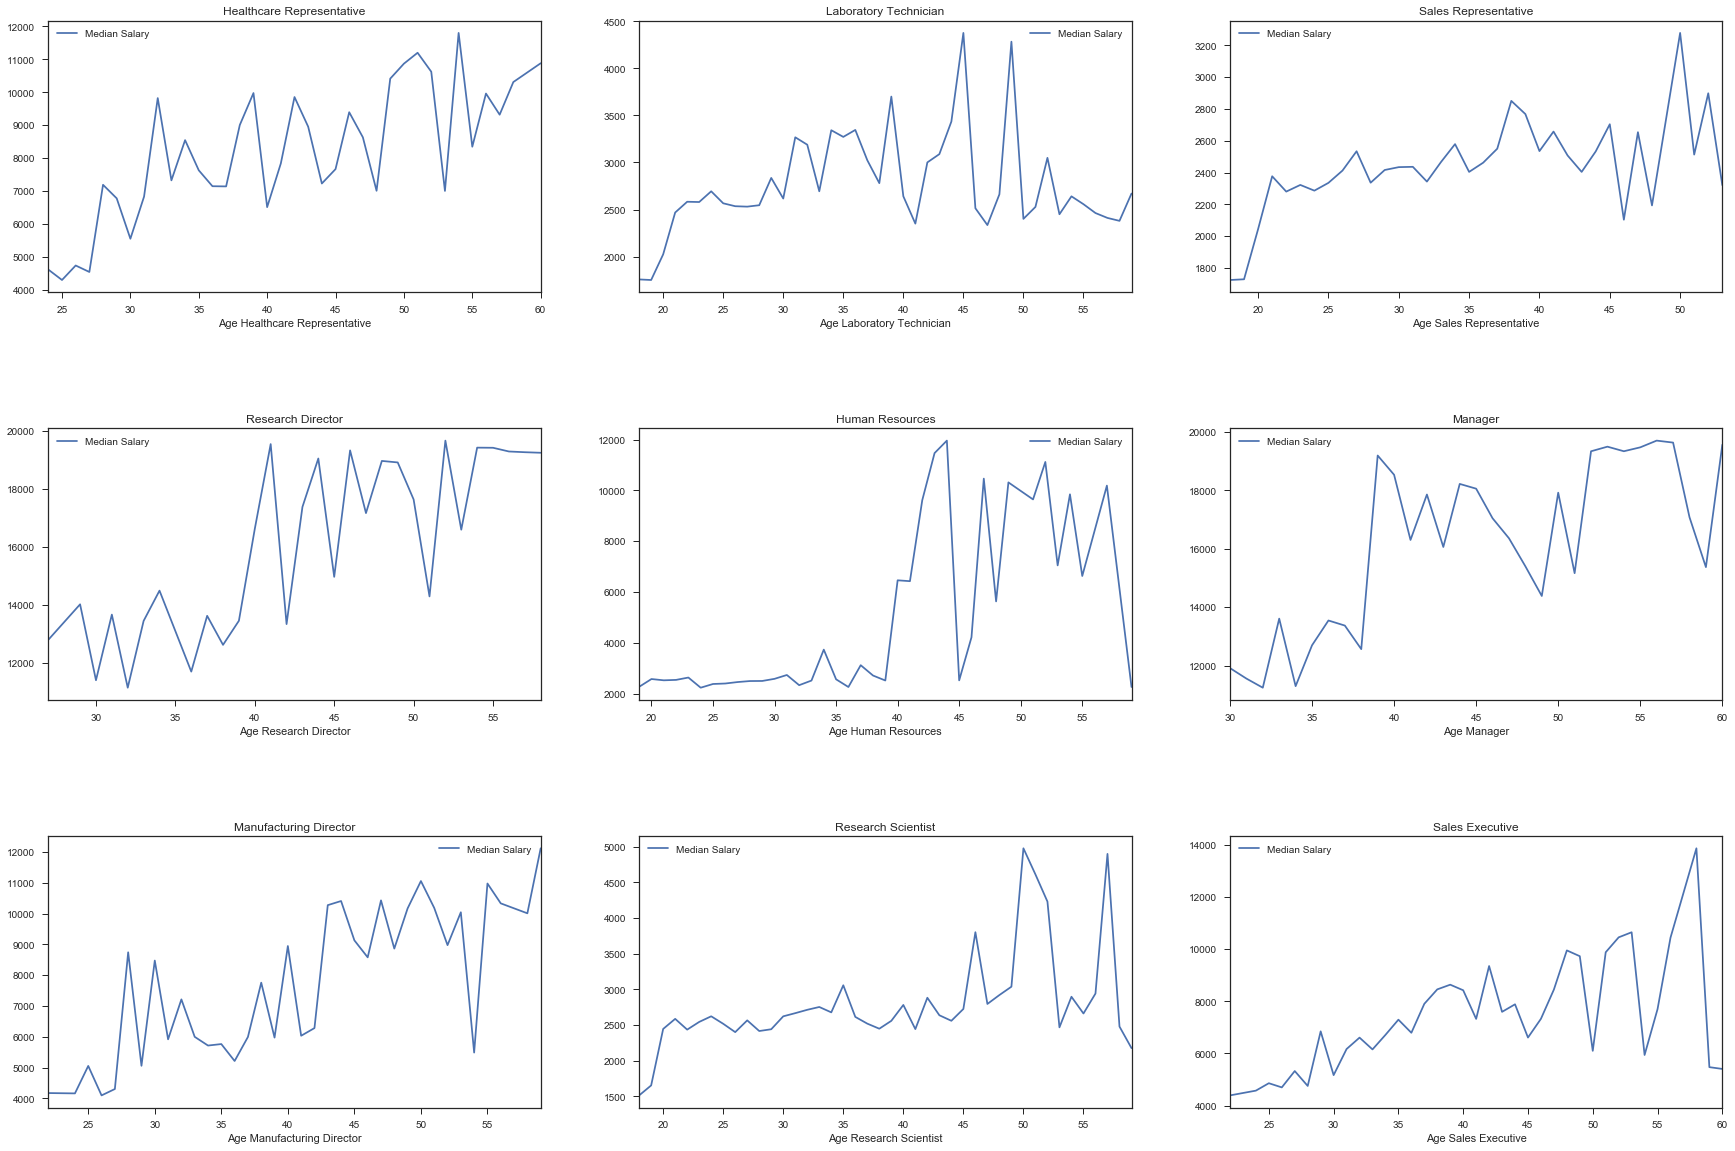

In [20]:
%matplotlib inline
def salary_by_jobrole(df):
    fig, axes = plt.subplots(nrows=3, ncols=3)
    fig.subplots_adjust(hspace=.5)
    
    rows = cols = 0
        
    for job in set(df.JobRole):
        agesalary = []
        for i in range(df['Age'].min(), df['Age'].max() + 1):
            agesalary.append([i, df[(df['Age'] == i) & (df['JobRole'] == job)]['MonthlyIncome'].median()])
        agesalary = pd.DataFrame(agesalary, columns=['Age '+job, 'Median Salary'])
        agesalary = agesalary.dropna().reset_index(drop=True)
       
        agesalary.plot(x='Age '+job, y='Median Salary', title=job, ax=axes[rows,cols], figsize=(30,20))
        
        if cols == 2:
            cols = 0
            rows += 1
        else:
            cols += 1

salary_by_jobrole(ibm_data)

# Pairwise plots for IBM HR

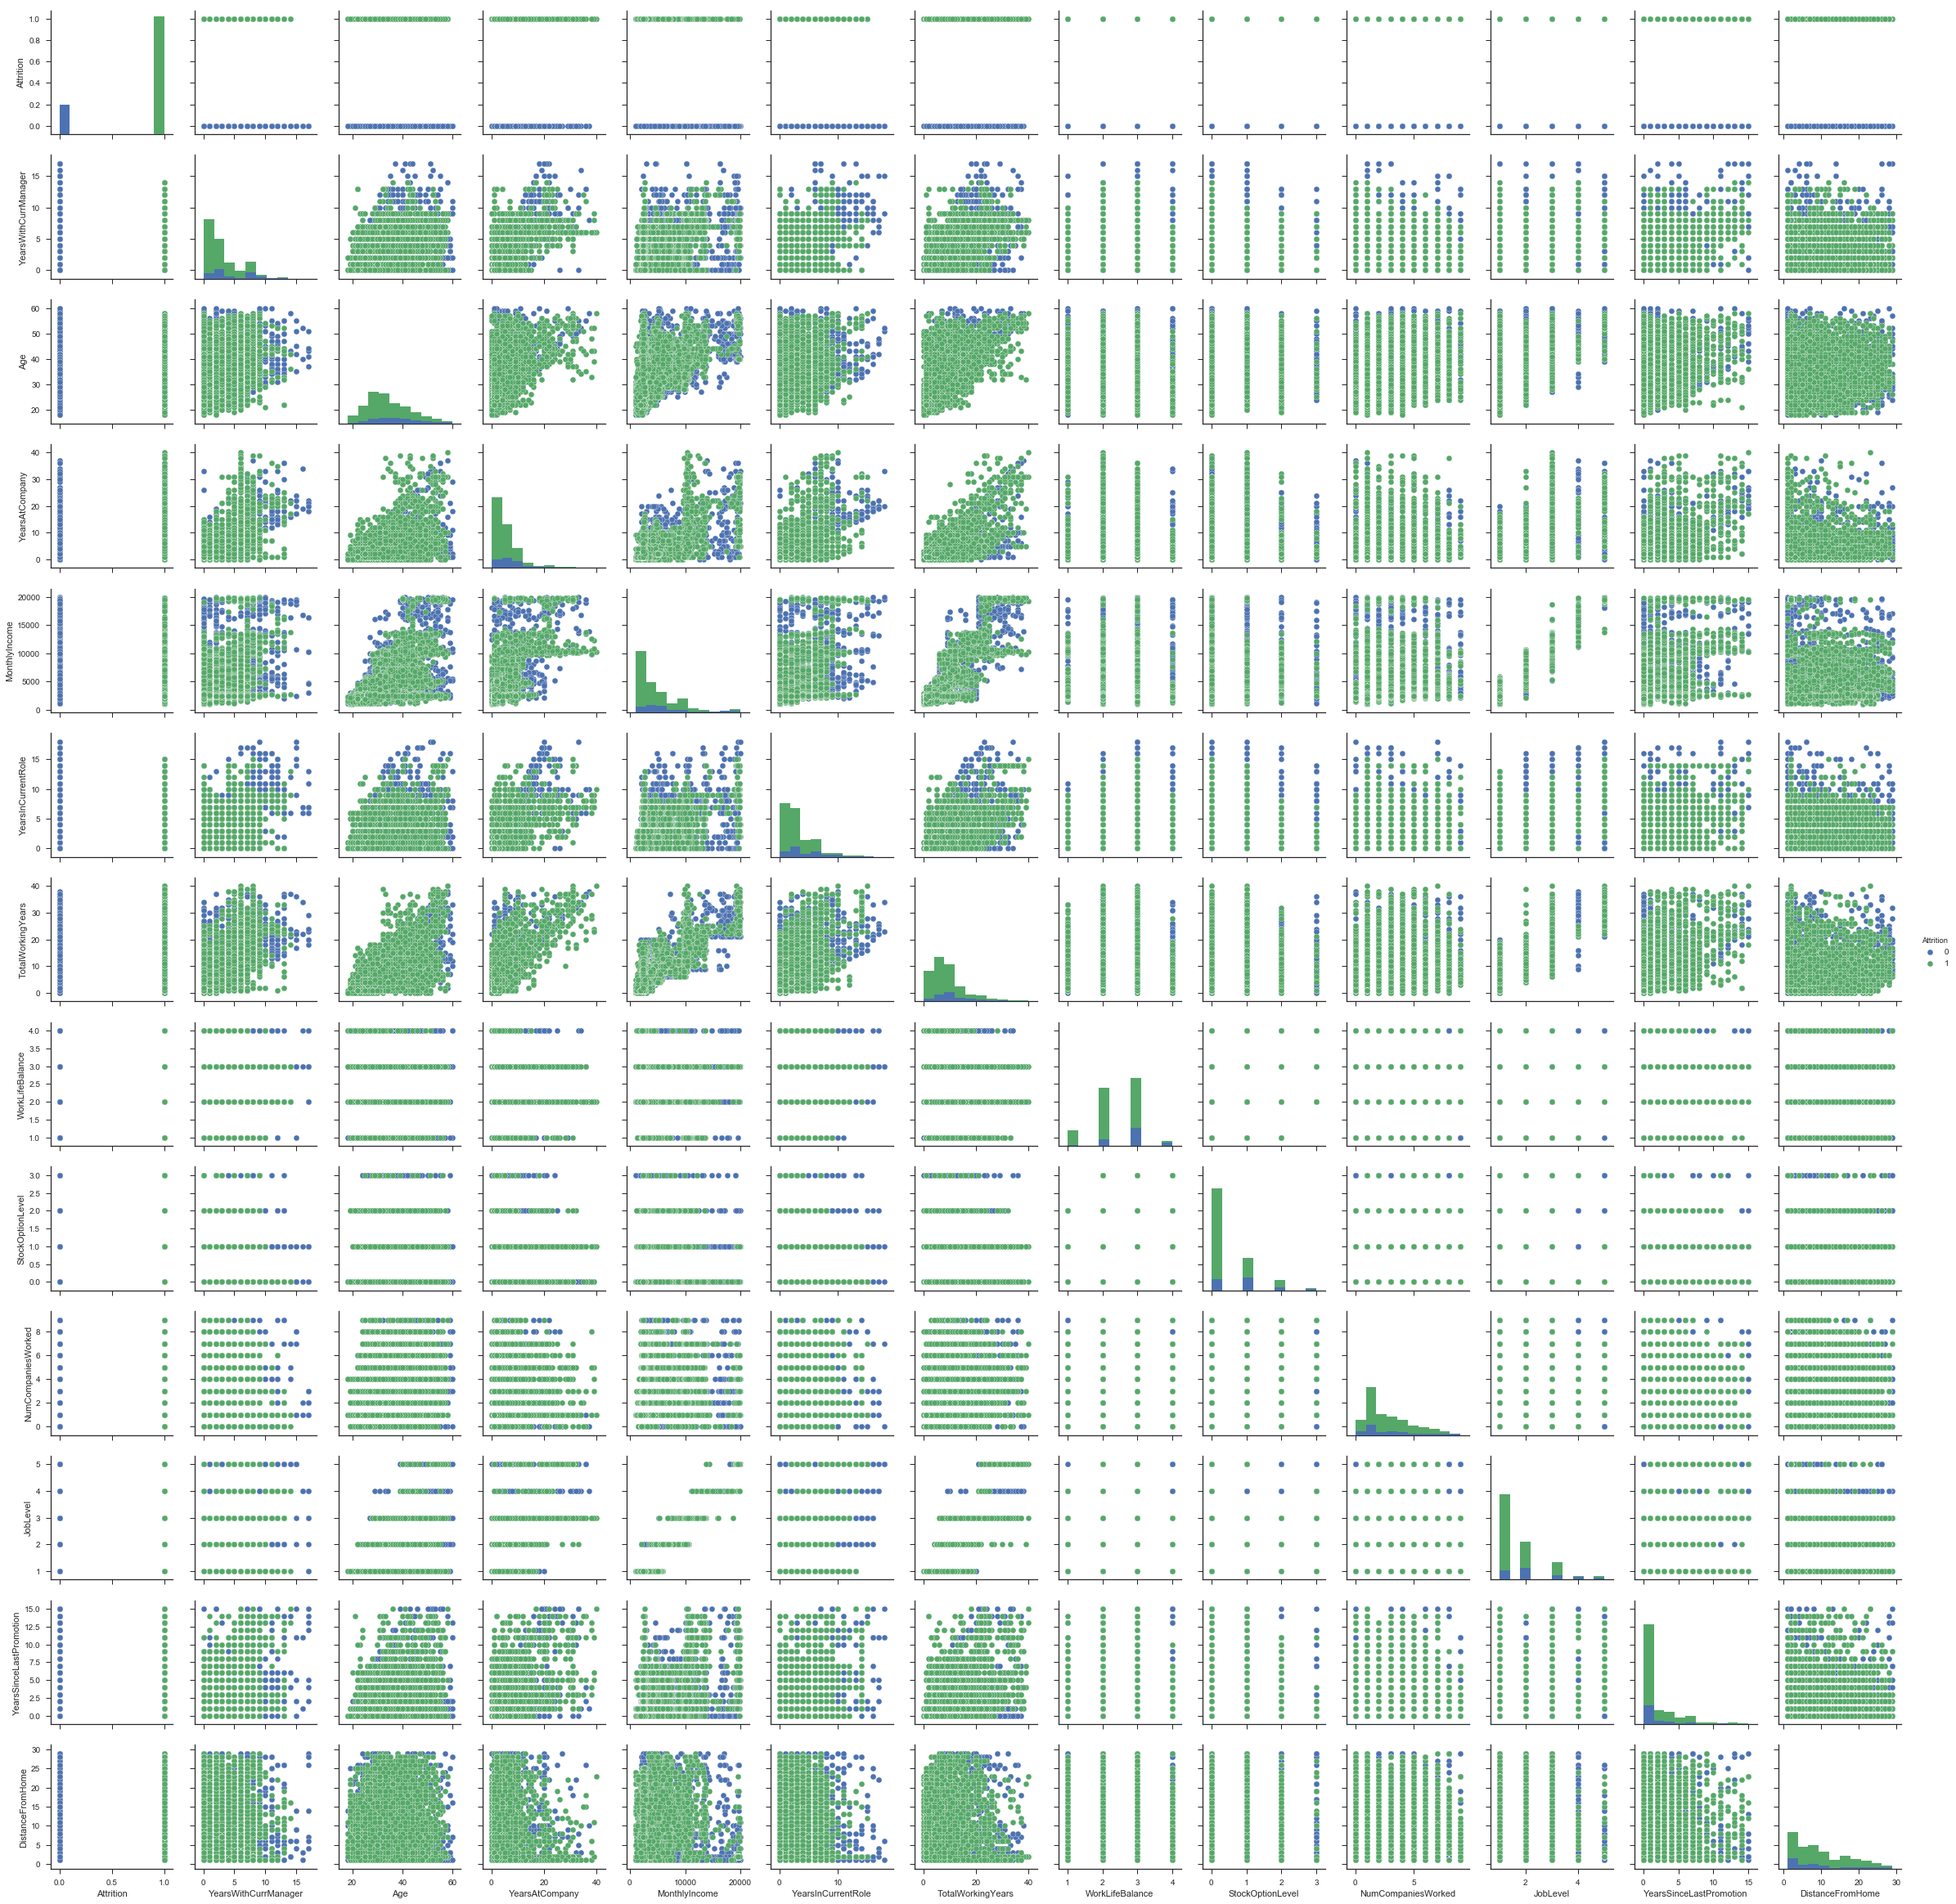

In [29]:
def att_to_cat(val):
    return 0 if val == "No" else 1

ibm_data["Attrition"] = [att_to_cat(x) for x in ibm_data.Attrition.values]

ibm_data.MaritalStatus = pd.Categorical(ibm_data.MaritalStatus).codes

# Out of 35 columns these have some relations (Mentioned in ibm_analysis.txt)
columns_to_plot = ['Attrition', 'YearsWithCurrManager', 'Age', 'YearsAtCompany', 'MonthlyIncome', 
                   'YearsInCurrentRole', 'TotalWorkingYears', 'WorkLifeBalance', 'StockOptionLevel',
                  'NumCompaniesWorked', 'JobLevel', 'YearsSinceLastPromotion', 'DistanceFromHome']

g = sns.pairplot(ibm_data[columns_to_plot], hue='Attrition')
plt.show()

# Pairwise plots for XYZ HR

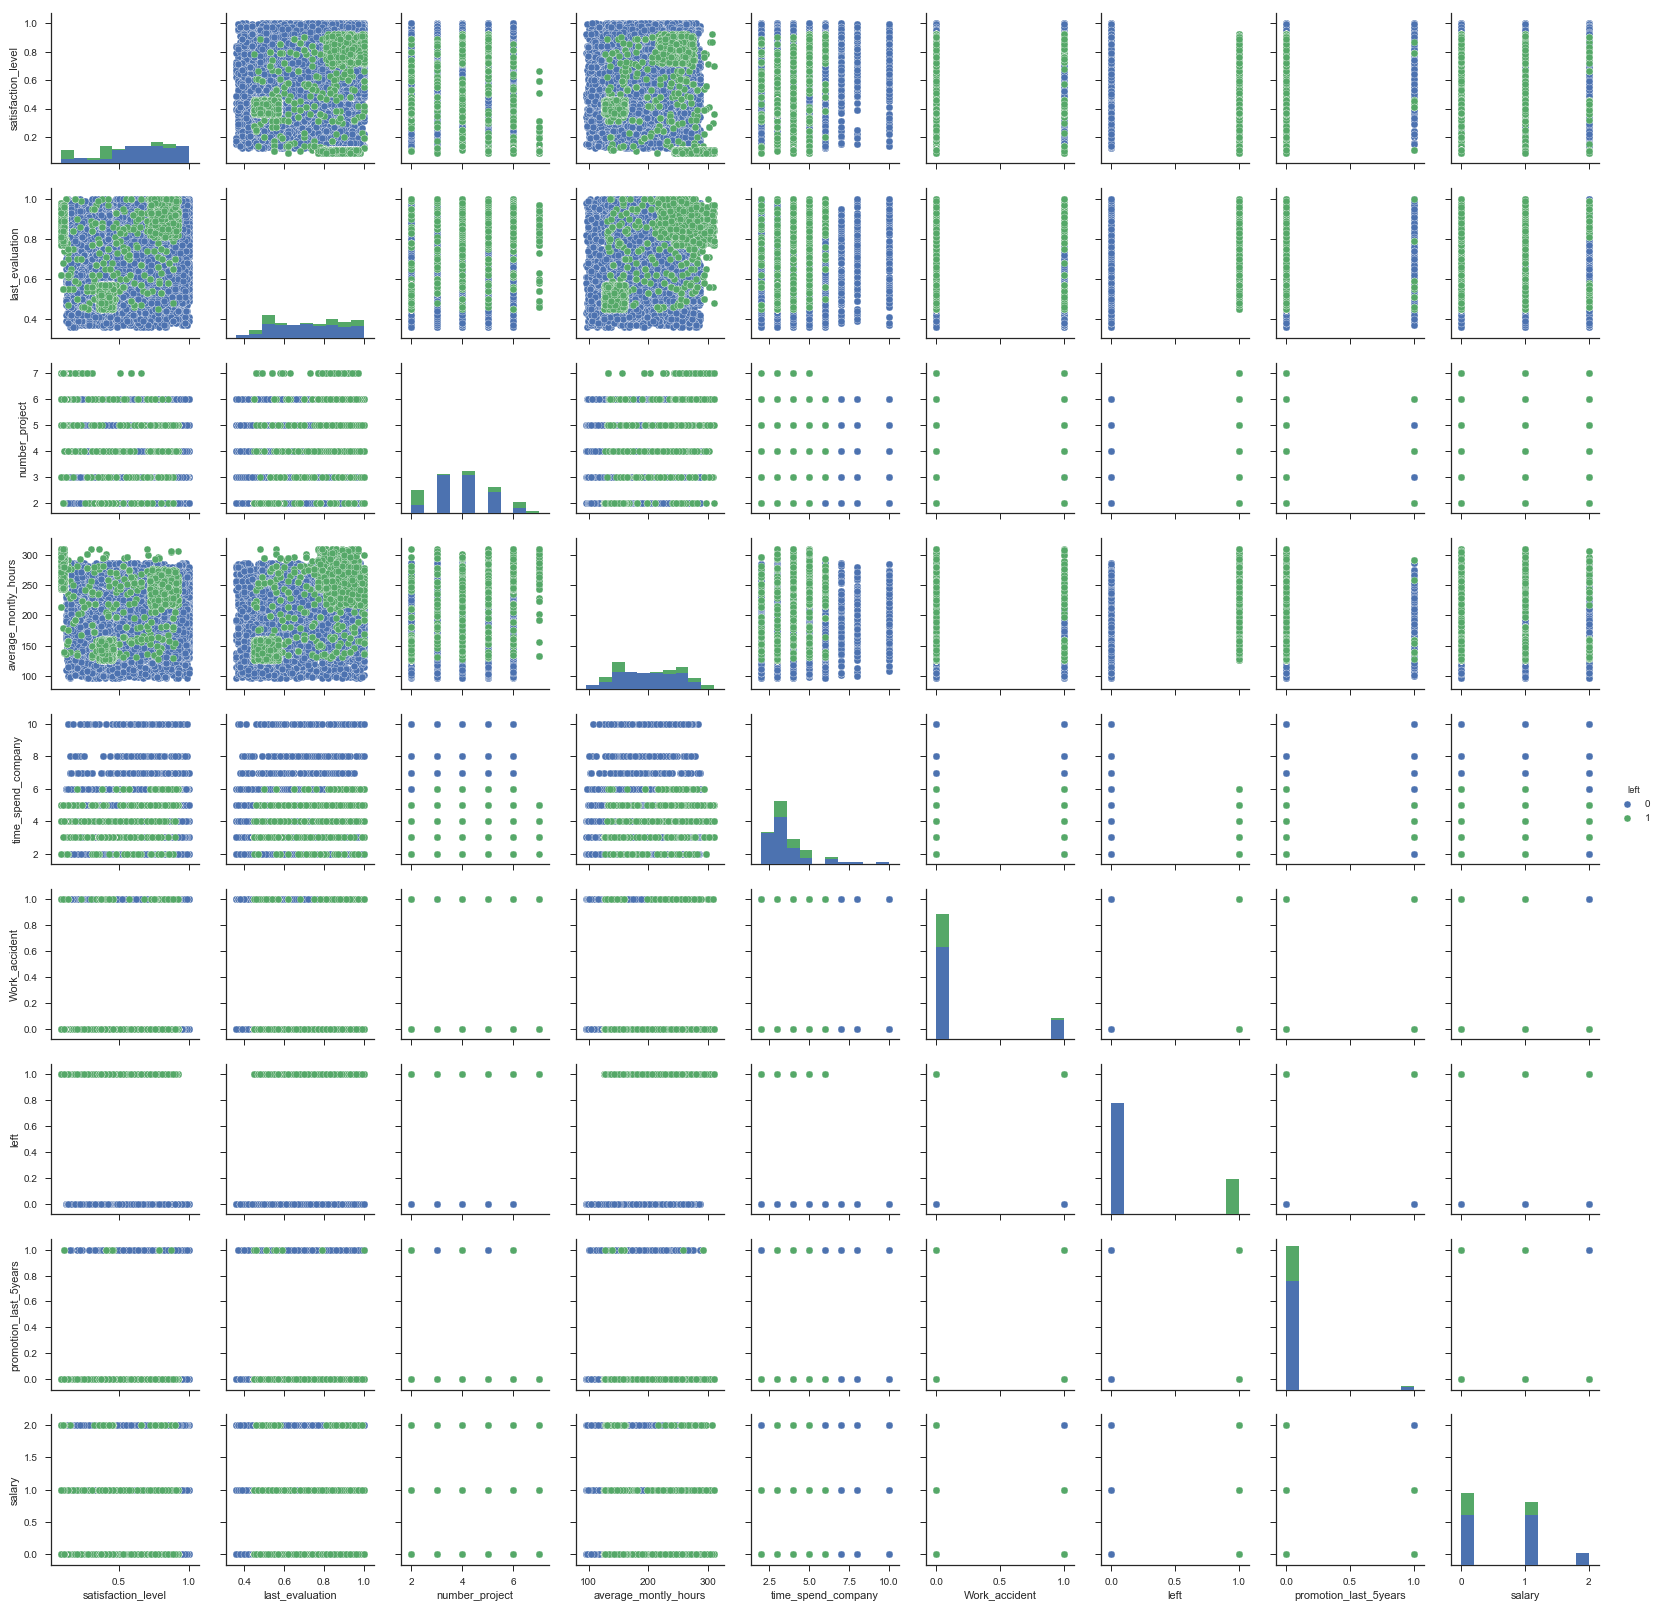

In [27]:
xyz_df = copy.deepcopy(xyz_data)
xyz_df_cpy = copy.deepcopy(xyz_df)

salary_map = {'low': 0, 'medium': 1, 'high': 2}

incomes = [salary_map[x] for x in xyz_df_cpy["salary"].values]
xyz_df_cpy["salary"] = incomes

g = sns.pairplot(xyz_df_cpy, hue='left')
plt.show()

# Comparing Attrition vs Other Values

In [ ]:
def pairplots_attritions(df):
    columns = list(df.columns)
    yval = ''
    
    # Remove attrition from columns to plot on x axis
    if 'Attrition' in columns:
        columns.remove('Attrition')
        yval = 'Attrition'
    elif 'left' in columns:
        columns.remove('left')
        yval = 'left'
    
    pp = sns.pairplot(data=df,y_vars=[yval],x_vars=columns, hue=yval)
    pp.fig.set_size_inches(100, 5)
    plt.show()

pairplots_attritions(ibm_data)
pairplots_attritions(xyz_data)

# Employee Turnovers

In [8]:
turnover_Summary = xyz_data.groupby('left')
turnover_Summary.mean()

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,promotion_last_5years,salary
left,,,,,,,,
0,0.666810,0.715473,3.786664,199.060203,3.380032,0.175009,0.026251,0.650945
1,0.440098,0.718113,3.855503,207.419210,3.876505,0.047326,0.005321,0.414730


In [9]:
turnover_Summary2 = ibm_data.groupby('Attrition')
turnover_Summary2.mean()

,Age,DistanceFromHome,EnvironmentSatisfaction,JobInvolvement,JobLevel,JobSatisfaction,MaritalStatus,MonthlyIncome,MonthlyRate,NumCompaniesWorked,...,PerformanceRating,RelationshipSatisfaction,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
Attrition,,,,,,,,,,,,,,,,,,,,,
0,37.561233,8.915653,2.771290,2.770479,2.145985,2.778589,1.045418,6832.739659,14265.779400,2.645580,...,3.153285,2.733982,0.845093,11.862936,2.832928,2.781022,7.369019,4.484185,2.234388,4.367397
1,33.471569,10.140848,2.131404,2.207555,1.521800,2.112518,1.332530,4741.488045,14570.233474,2.661242,...,3.033153,2.250352,0.295961,8.011855,2.302994,2.330319,4.646373,2.497087,1.579867,2.457304


# Correlation Matrix XYZ

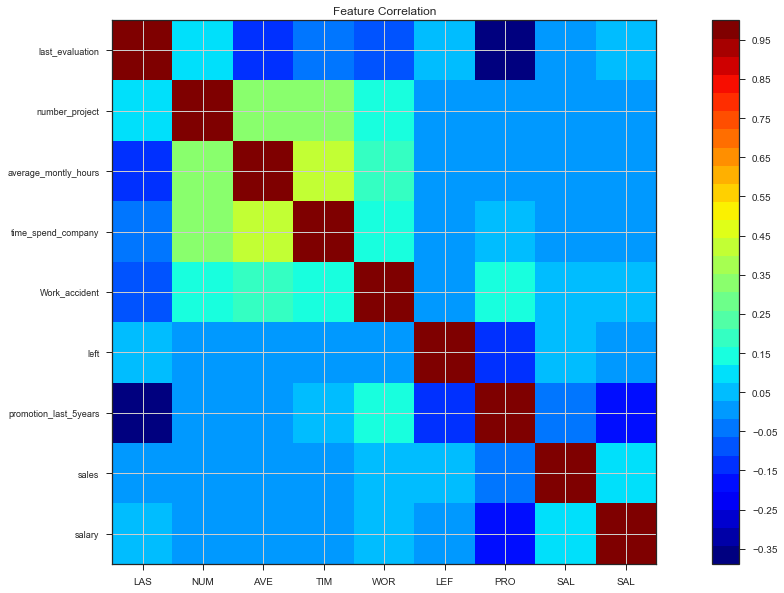

In [10]:
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import cm as cm

def correlation_matrix(df):
    fig = plt.figure(figsize=(20, 10))
    ax1 = fig.add_subplot(111)
    cmap = cm.get_cmap('jet', 30)
    cax = ax1.imshow(df.corr(), interpolation="nearest", cmap=cmap)
    ax1.grid(True)
    plt.title('Feature Correlation')
    labels=df.columns
    xlabels = [x[0:3].upper() for x in labels]
    ax1.set_xticklabels(xlabels,fontsize=10)
    ax1.set_yticklabels(labels,fontsize=9)
    # Add colorbar, make sure to specify tick locations to match desired ticklabels
    fig.colorbar(cax, ticks=np.arange(-0.75,1,0.1))
    plt.show()

correlation_matrix(xyz_data)

# Correlation Matrix IBM

,Age,Attrition,DistanceFromHome,EnvironmentSatisfaction,JobInvolvement,JobLevel,JobSatisfaction,MaritalStatus,MonthlyIncome,MonthlyRate,...,PerformanceRating,RelationshipSatisfaction,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
Age,1.000000,-0.191945,-0.000668,0.035348,0.076234,0.572351,0.050180,-0.103532,0.557914,-0.034587,...,0.026935,0.128931,0.136957,0.626105,0.012969,0.049925,0.426981,0.350705,0.324866,0.344094
Attrition,-0.191945,1.000000,0.067412,-0.258563,-0.310319,-0.268899,-0.266261,0.157362,-0.214468,0.016996,...,-0.206691,-0.195686,-0.320748,-0.219228,-0.195509,-0.246912,-0.196195,-0.271778,-0.097062,-0.259962
DistanceFromHome,-0.000668,0.067412,1.000000,-0.049376,0.026921,0.024219,-0.030300,-0.051903,0.000890,0.035715,...,0.012861,-0.062151,0.022979,-0.037225,-0.102389,-0.087514,-0.040669,-0.021292,-0.033916,-0.029720
EnvironmentSatisfaction,0.035348,-0.258563,-0.049376,1.000000,0.149334,0.011908,0.085024,0.004210,-0.022048,0.005584,...,0.078450,0.076946,0.025553,0.012471,0.089432,0.078676,0.036389,0.054413,0.061472,0.061124
JobInvolvement,0.076234,-0.310319,0.026921,0.149334,1.000000,0.072701,0.035597,-0.034049,0.050336,-0.015584,...,0.073866,0.070003,0.139754,0.040084,0.040650,0.130657,0.036552,0.061337,0.022371,0.114122
JobLevel,0.572351,-0.268899,0.024219,0.011908,0.072701,1.000000,0.062822,-0.106530,0.942152,0.088259,...,0.049062,0.128420,0.129352,0.797354,-0.030709,0.110477,0.611750,0.538810,0.432995,0.470947
JobSatisfaction,0.050180,-0.266261,-0.030300,0.085024,0.035597,0.062822,1.000000,-0.067135,0.030075,0.136309,...,0.006509,0.114331,0.080434,0.057012,0.080220,0.013717,0.057625,0.029419,0.051055,0.017752
MaritalStatus,-0.103532,0.157362,-0.051903,0.004210,-0.034049,-0.106530,-0.067135,1.000000,-0.087113,-0.000395,...,-0.018642,-0.038970,-0.379019,-0.109484,0.020165,-0.024700,-0.067740,-0.072337,-0.020522,-0.019803
MonthlyIncome,0.557914,-0.214468,0.000890,-0.022048,0.050336,0.942152,0.030075,-0.087113,1.000000,0.072353,...,0.044540,0.122008,0.103228,0.798316,-0.037566,0.099096,0.611192,0.526839,0.440205,0.469253
MonthlyRate,-0.034587,0.016996,0.035715,0.005584,-0.015584,0.088259,0.136309,-0.000395,0.072353,1.000000,...,-0.015956,0.018629,-0.104576,-0.008213,-0.044796,-0.014179,-0.076011,-0.065549,-0.065172,-0.134719


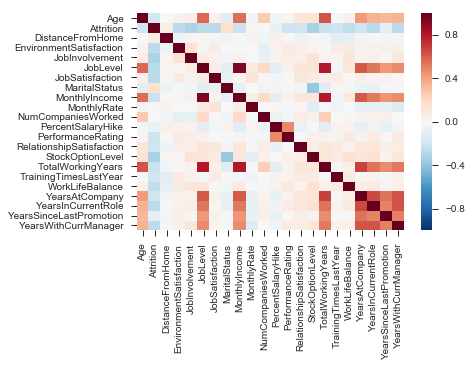

In [11]:
corr = ibm_data.corr()
corr = (corr)
sns.heatmap(corr, 
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values)

corr

## Summary:

 From the heatmap, there is a positive(+) correlation between projectCount, averageMonthlyHours, and evaluation. Which could mean that the employees who spent more hours and did more projects were evaluated highly.

 For the negative(-) relationships, turnover and satisfaction are highly correlated. I'm assuming that people tend to leave a company more when they are less satisfied.


## Salary vs TurnOver
### XYZ HR

Text(0.5,1,u'Employee Salary Turnover Distribution')

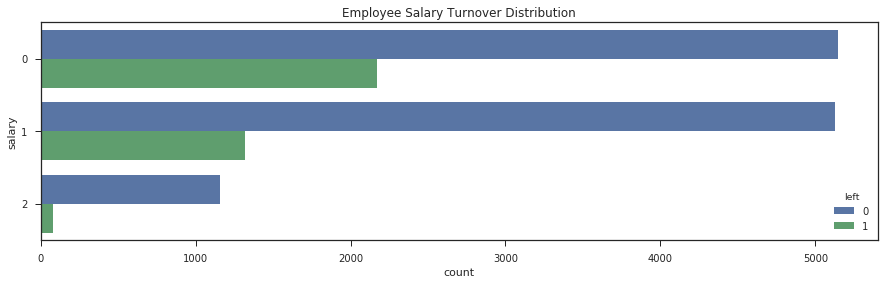

In [11]:
f, ax = plt.subplots(figsize=(15, 4))
sns.countplot(y="salary", hue='left', data=xyz_data).set_title('Employee Salary Turnover Distribution')

### IBM HR


Text(0.5,1,u'Employee Salary Turnover Distribution for IBM')

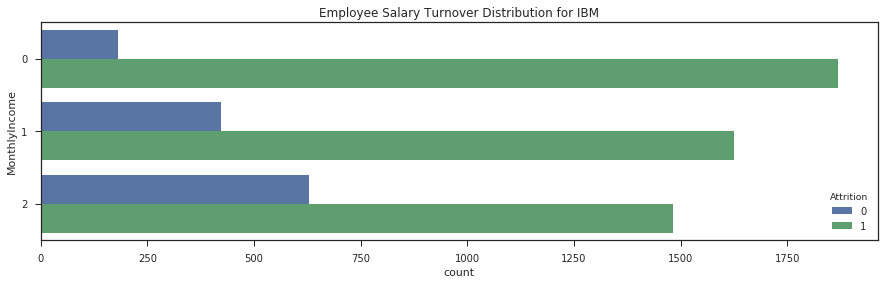

In [12]:
import numpy as np

low_sal = ibm_data['MonthlyIncome']

a = np.array(ibm_data['MonthlyIncome'])
low_range = np.percentile(a, 33) 
medium_range = np.percentile(a, 66)


def cat_to_sal(sal):
    if sal <= low_range:
        return 0
    elif sal >= low_range and sal < medium_range:
        return 1
    elif sal >= medium_range:
        return 2
    
incomes = [cat_to_sal(x) for x in ibm_data['MonthlyIncome'].values]
ibm_data["MonthlyIncome"] = incomes


f, ax = plt.subplots(figsize=(15, 4))
sns.countplot(y="MonthlyIncome", hue='Attrition', data=ibm_data).set_title('Employee Salary Turnover Distribution for IBM')


# Histogram Plots

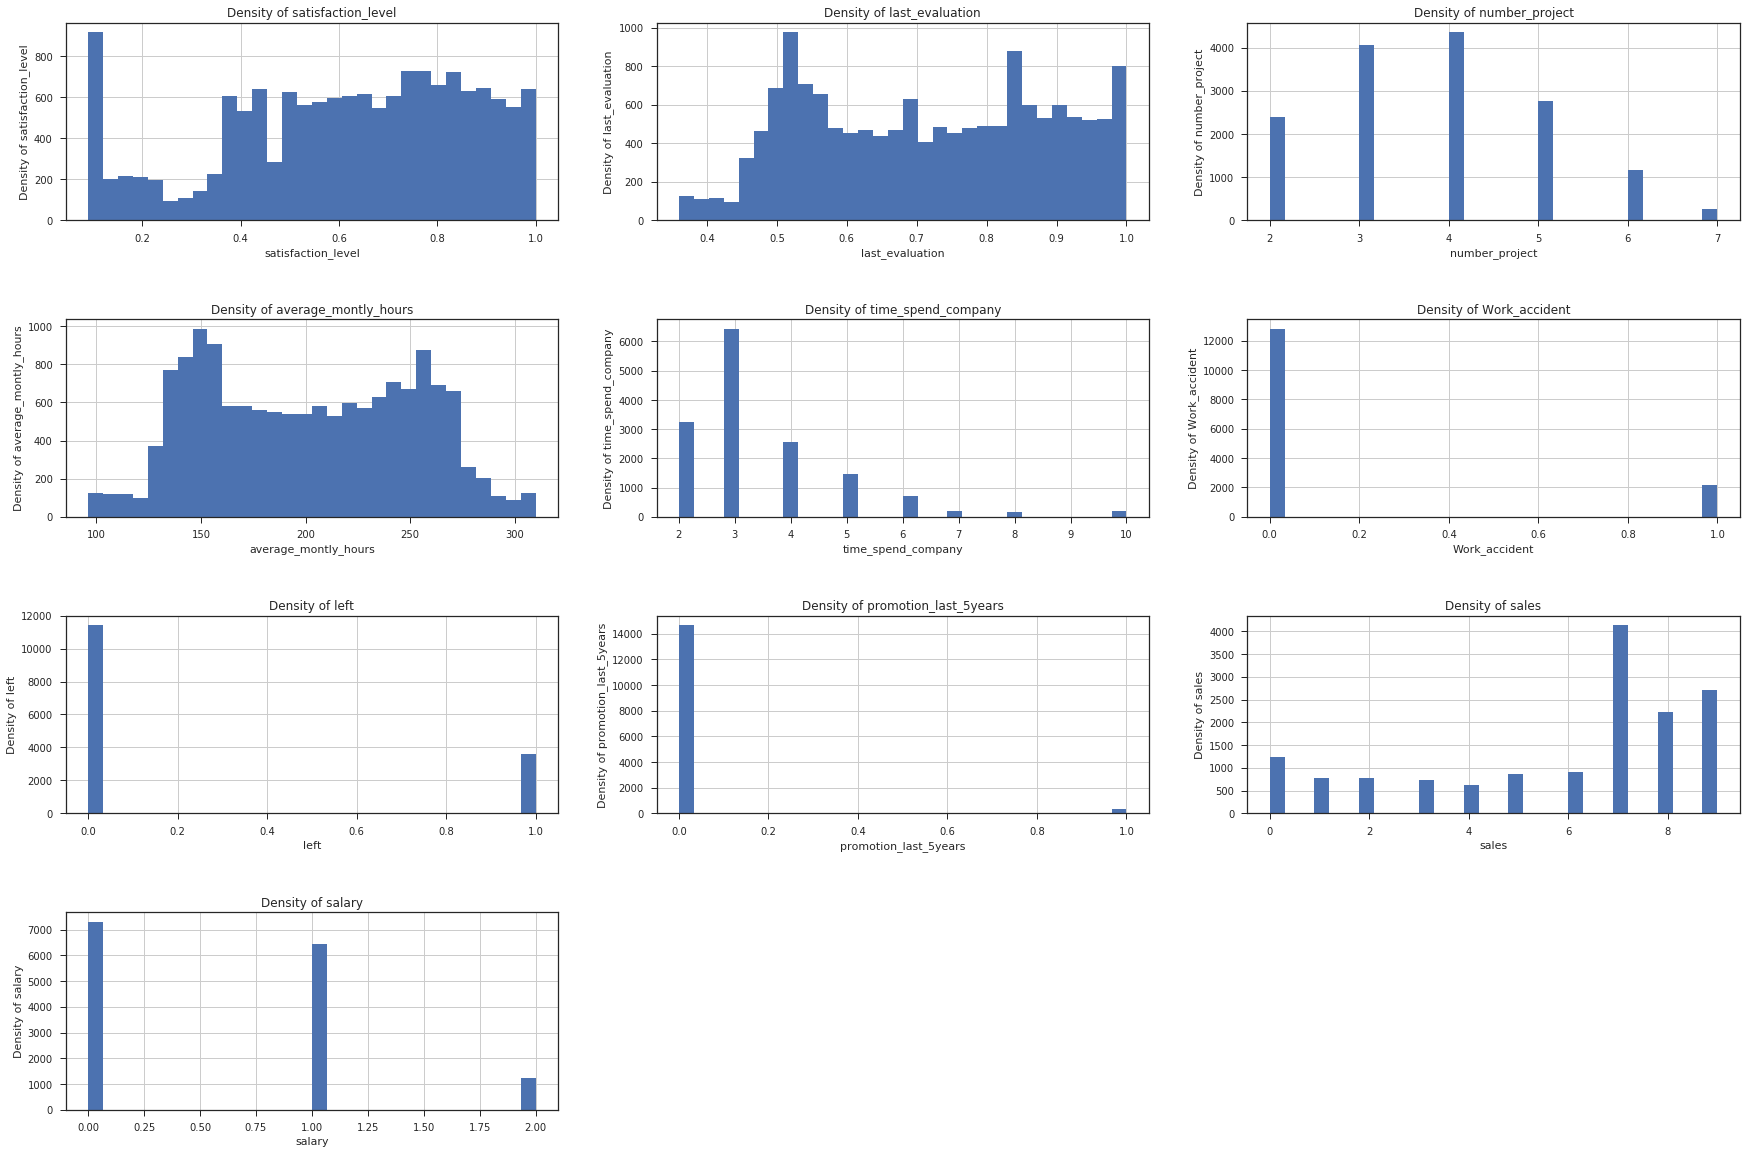

In [13]:
import matplotlib.pyplot as plt

xyz_data.sales  = pd.Categorical(xyz_data.sales).codes

def hr_hist(df):    
    rowval = colval = 0
    fig, axes = plt.subplots(nrows=4, ncols=3)
    fig.subplots_adjust(hspace=.5)
    
    
    cols = df.columns
    ## Loop over columns and plot histograms
    for col in cols:
        data_plot = df[col].hist(bins = 30, ax = axes[rowval,colval], figsize=(30,20))
        
        data_plot.set_xlabel(col)
        data_plot.set_ylabel('Density of ' + col)
        data_plot.set_title('Density of ' + col)
        
        if colval == 2:
            colval = 0
            rowval += 1
        else:
            colval += 1

    fig.delaxes(axes[3][1])
    fig.delaxes(axes[3][2])
        
hr_hist(xyz_data)

# Integration and Pre-processing:

In [30]:
'''Some Helper Functions'''

def LoadData(path):
    return pd.read_csv(path)
    
def MergeDataSets(df1,df2):
    result = df1.append(df2, ignore_index=True)
    return result

def combined_dfs(df1, df2):
    return df1.append(df2, ignore_index=True)
    
def MergeDataSetToCsv(path,df):
    df.to_csv(path,sep = ',',encoding='utf-8')
    return

In [43]:
df_ibm = LoadData("HR_IBM.csv")
df_xyz = LoadData("organization.csv")
result = combined_dfs(df_ibm, df_xyz)
result.shape

(21209, 45)

### Merge Common Features:

In [34]:
def satisfaction_combine(result):
    result['satisfaction_level_Combined'] = np.where(result['satisfaction_level'].between(0.76, 1), 4,
                                                     result['satisfaction_level'])
    result['satisfaction_level_Combined'] = np.where(result['satisfaction_level_Combined'].between(0.51, 0.75), 3,
                                                     result['satisfaction_level_Combined'])
    result['satisfaction_level_Combined'] = np.where(result['satisfaction_level_Combined'].between(0.26, 0.50), 2,
                                                     result['satisfaction_level_Combined'])
    result['satisfaction_level_Combined'] = np.where(result['satisfaction_level_Combined'].between(0.0, 0.25), 1,
                                                     result['satisfaction_level_Combined'])
    result.satisfaction_level_Combined.fillna(result.JobSatisfaction, inplace=True)

    fields_to_drop.extend(['satisfaction_level','JobSatisfaction'])


def years_at_company_combine(result):
    result['YearsAtCompanyCombied'] = result.time_spend_company.fillna(result.YearsAtCompany)
    fields_to_drop.extend(['time_spend_company', 'YearsAtCompany'])

def combine_attritions(result):
    def mapper(val):
        if val == 'Yes':
            return 1
        elif val == 'No':
            return 0
        else:
            return val

    result['attrition_combined'] = [mapper(x) for x in result['Attrition'].values]
    result.attrition_combined.fillna(result.left, inplace=True)
    result.attrition_combined = result.attrition_combined.astype(int)
    fields_to_drop.extend(['Attrition', 'left'])

def incomes_combined(result):
    def sal_mapper(val):
        if val == 'low':
            return 0
        elif val == 'medium':
            return 1
        elif val == 'high':
            return 2
        else:
            return val

    def cat_to_sal(sal):
        if sal <= low_range:
            return 0
        elif sal >= low_range and sal < medium_range:
            return 1
        elif sal >= medium_range:
            return 2
        else:
            return sal

    # Convery salary from low,med,high to 0,1,2
    result['salary'] = [sal_mapper(x) for x in result.salary]

    a = np.array(result['MonthlyIncome'])
    low_range = np.nanpercentile(a, 33)
    medium_range = np.nanpercentile(a, 66)

    # Create new column from monthlyincome based on percentiles and categorize
    result['salary_combined'] = [cat_to_sal(x) for x in result.MonthlyIncome]

    result.salary_combined.fillna(result.salary, inplace=True)
    result.salary_combined = result.salary_combined.astype(int)

    fields_to_drop.extend(['salary', 'MonthlyIncome'])

def combine_departments(result):
    def mapper(val):
        if val == 'Sales':
            return val.lower()
        elif val == 'Research & Development':
            return 'RandD'
        elif val == 'Human Resources':
            return 'hr'
        else:
            return val

    result['department_combined'] = [mapper(x) for x in result['Department'].values]
    result.department_combined.fillna(result.sales, inplace=True)
    dept_map = {'sales':1, 'RandD':2, 'hr':3, 'accounting':4, 'technical':5, 'support':6,
       'management':7, 'IT':8, 'product_mng':9, 'marketing':10}
    result['department_combined'] = [dept_map[x] for x in result['department_combined'].values]
    
    result.department_combined = result.department_combined.astype(int)
    fields_to_drop.extend(['Department', 'sales'])


def combine_promotion_last_5_years(result):
    def mapper(val):
        if val <= 5:
            return 1
        else:
            return 0

    result['promotion_5_year_combined'] = [mapper(x) for x in result['YearsSinceLastPromotion'].values]
    result.promotion_5_year_combined.fillna(result.promotion_last_5years, inplace=True)
    result.promotion_5_year_combined = result.promotion_5_year_combined.astype(int)
    fields_to_drop.extend(['YearsSinceLastPromotion', 'promotion_last_5years'])

In [45]:
satisfaction_combine(result)
years_at_company_combine(result)
combine_attritions(result)
incomes_combined(result)
combine_departments(result)
combine_promotion_last_5_years(result)

### Categorical to Numerical Conversion

In [50]:
def ConvertCategoricalFeaturesToNumerical(result_Combined):
    result_Combined['BusinessTravel_numerical'] = result_Combined.loc[result_Combined.BusinessTravel == 'Travel_Rarely', 'BusinessTravel'] = 1
    result_Combined['BusinessTravel_numerical'] = result_Combined.loc[result_Combined.BusinessTravel == 'Travel_Frequently', 'BusinessTravel'] = 2
    result_Combined['BusinessTravel_numerical'] = result_Combined.loc[result_Combined.BusinessTravel == 'Non-Travel', 'BusinessTravel'] = 0
    result_Combined['BusinessTravel_numerical'] = result_Combined['BusinessTravel'].convert_objects(convert_numeric=True)
    
    
    result_Combined['Gender_numerical'] = result_Combined.loc[result_Combined.Gender == 'Female', 'Gender'] = 0
    result_Combined['Gender_numerical'] = result_Combined.loc[result_Combined.Gender == 'Male', 'Gender'] = 1
    result_Combined['Gender_numerical'] = result_Combined['Gender'].convert_objects(convert_numeric=True)
    
    
    result_Combined['EducationField_numerical'] = result_Combined.loc[result_Combined.EducationField == 'Life Sciences', 'EducationField'] = 0
    result_Combined['EducationField_numerical'] = result_Combined.loc[result_Combined.EducationField == 'Other', 'EducationField'] = 1
    result_Combined['EducationField_numerical'] = result_Combined.loc[result_Combined.EducationField == 'Medical', 'EducationField'] = 2
    result_Combined['EducationField_numerical'] = result_Combined.loc[result_Combined.EducationField == 'Marketing', 'EducationField'] = 3
    result_Combined['EducationField_numerical'] = result_Combined.loc[result_Combined.EducationField == 'Technical Degree', 'EducationField'] = 4
    result_Combined['EducationField_numerical'] = result_Combined.loc[result_Combined.EducationField == 'Human Resources', 'EducationField'] = 5
    result_Combined['EducationField_numerical'] = result_Combined['EducationField'].convert_objects(convert_numeric=True)
    
    result_Combined['MaritalStatus_numerical'] = result_Combined.loc[result_Combined.MaritalStatus == 'Single', 'MaritalStatus'] = 0
    result_Combined['MaritalStatus_numerical'] = result_Combined.loc[result_Combined.MaritalStatus == 'Married', 'MaritalStatus'] = 1
    result_Combined['MaritalStatus_numerical'] = result_Combined.loc[result_Combined.MaritalStatus == 'Divorced', 'MaritalStatus'] = 2
    result_Combined['MaritalStatus_numerical'] = result_Combined['MaritalStatus'].convert_objects(convert_numeric=True)
    
    
    result_Combined['OverTime_numerical'] = result_Combined.loc[result_Combined.OverTime == 'No', 'OverTime'] = 0
    result_Combined['OverTime_numerical'] = result_Combined.loc[result_Combined.OverTime == 'Yes', 'OverTime'] = 1
    result_Combined['OverTime_numerical'] = result_Combined['OverTime'].convert_objects(convert_numeric=True)
    
    result_Combined['JobRole_numerical'] = result_Combined.loc[result_Combined.JobRole == 'Sales Executive', 'JobRole'] = 0
    result_Combined['JobRole_numerical'] = result_Combined.loc[result_Combined.JobRole == 'Research Scientist', 'JobRole'] = 1
    result_Combined['JobRole_numerical'] = result_Combined.loc[result_Combined.JobRole == 'Laboratory Technician', 'JobRole'] = 2
    result_Combined['JobRole_numerical'] = result_Combined.loc[result_Combined.JobRole == 'Manufacturing Director', 'JobRole'] = 3
    result_Combined['JobRole_numerical'] = result_Combined.loc[result_Combined.JobRole == 'Healthcare Representative', 'JobRole'] = 4
    result_Combined['JobRole_numerical'] = result_Combined.loc[result_Combined.JobRole == 'Manager', 'JobRole'] = 5
    result_Combined['JobRole_numerical'] = result_Combined.loc[result_Combined.JobRole == 'Sales Representative', 'JobRole'] = 6
    result_Combined['JobRole_numerical'] = result_Combined.loc[result_Combined.JobRole == 'Research Director', 'JobRole'] = 7
    result_Combined['JobRole_numerical'] = result_Combined.loc[result_Combined.JobRole == 'Human Resources', 'JobRole'] = 8
    result_Combined['JobRole_numerical'] = result_Combined['JobRole'].convert_objects(convert_numeric=True)
    fields_to_drop.extend(['BusinessTravel','Gender','EducationField','MaritalStatus','OverTime','JobRole'])

In [51]:
ConvertCategoricalFeaturesToNumerical(result)

C:\Users\Mudassir\Anaconda2\lib\site-packages\ipykernel_launcher.py:5: FutureWarning: convert_objects is deprecated.  Use the data-type specific converters pd.to_datetime, pd.to_timedelta and pd.to_numeric.
  """
C:\Users\Mudassir\Anaconda2\lib\site-packages\ipykernel_launcher.py:10: FutureWarning: convert_objects is deprecated.  Use the data-type specific converters pd.to_datetime, pd.to_timedelta and pd.to_numeric.
  # Remove the CWD from sys.path while we load stuff.
C:\Users\Mudassir\Anaconda2\lib\site-packages\ipykernel_launcher.py:19: FutureWarning: convert_objects is deprecated.  Use the data-type specific converters pd.to_datetime, pd.to_timedelta and pd.to_numeric.
C:\Users\Mudassir\Anaconda2\lib\site-packages\ipykernel_launcher.py:24: FutureWarning: convert_objects is deprecated.  Use the data-type specific converters pd.to_datetime, pd.to_timedelta and pd.to_numeric.
C:\Users\Mudassir\Anaconda2\lib\site-packages\ipykernel_launcher.py:29: FutureWarning: convert_objects is dep

### Binning of Monthly Rate

In [33]:
def BinMonthlyRate(result):
    
    def BinMapper(x):
        if x <= first_range:
            return 0
        elif x >= first_range and x < second_range:
            return 1
        elif x >= second_range and x < third_range:
            return 2
        elif x >= third_range and x < fourth_range:
            return 3
        elif x >= fourth_range:
            return 4
        else:
            return x
    
    a = np.array(result['MonthlyRate'])
    first_range = np.nanpercentile(a, 20)
    second_range = np.nanpercentile(a, 40)
    third_range = np.nanpercentile(a, 60)
    fourth_range = np.nanpercentile(a, 80)
    
    result['MonthtlyRateNormalized'] = [BinMapper(x) for x in result.MonthlyRate]
    fields_to_drop.extend(['MonthlyRate'])

In [47]:
BinMonthlyRate(result)

#### Drop Useless fields

In [48]:
result_Combined = result.drop(fields_to_drop,axis=1)
result_Combined.shape

(21209, 32)

### Handle Missing Data

In [35]:
def MissingDataTreatment(result):
    for i in result.columns:
        med = np.nanmedian(result[i])
        result[i].fillna(med,inplace=True)
    return result

In [49]:
result_Combined = MissingDataTreatment(result_Combined)

### Split Data for Training and Testing

In [36]:
def splitdata(result_Combined):
    input_x = list(result_Combined.columns)
    input_x.remove('attrition_combined')
    X_train, X_test, y_train, y_test = train_test_split( result_Combined[input_x], result_Combined['attrition_combined'], test_size=0.33, random_state=42)
    return X_train, X_test, y_train, y_test

In [52]:
X_train, X_test, y_train, y_test = splitdata(result_Combined)

# Apply Models

### Logistic Regression

In [58]:
def TrainLogisticRegression(X_train, y_train):
    logmodel = LogisticRegression()
    logmodel.fit(X_train,y_train)
    return logmodel
    
def ScoreLogisticRegression(X_test, y_test,logmodel):
    predictions = logmodel.predict(X_test)
    report = classification_report(y_test,predictions)
    confuionMatrix = confusion_matrix(y_test,predictions)
    return predictions,report,confuionMatrix

In [59]:
logmodel = TrainLogisticRegression(X_train, y_train)
predictions_lr,report_lr,confuionMatrix_lr = ScoreLogisticRegression(X_test, y_test,logmodel)

### Decission Tree

In [60]:
def TrainDecissionTree(X_train, y_train):
    clf = tree.DecisionTreeClassifier()
    clf = clf.fit(X_train, y_train)
    return clf

def ScoreDecissionTree(X_test, y_test,clf):
    predictions = clf.predict(X_test)
    report = classification_report(y_test,predictions)
    confuionMatrix = confusion_matrix(y_test,predictions)
    return predictions,report,confuionMatrix

In [61]:
decission_tree_model = TrainDecissionTree(X_train, y_train)
predictions_dt,report_dt,confuionMatrix_dt = ScoreDecissionTree(X_test, y_test, decission_tree_model)

### Random Forest

In [62]:
def TrainRandomForest(X_train, y_train):
    clf = RandomForestClassifier(max_depth=2, random_state=0)
    clf = clf.fit(X_train, y_train)
    return clf

def ScoreRandomForest(X_test, y_test,clf):
    predictions = clf.predict(X_test)
    report = classification_report(y_test,predictions)
    confuionMatrix = confusion_matrix(y_test,predictions)
    return predictions,report,confuionMatrix

In [63]:
random_forest_model = TrainRandomForest(X_train, y_train)
predictions_rf,report_rf,confuionMatrix_rf = ScoreRandomForest(X_test, y_test, random_forest_model)

###  ROC Curves

In [64]:
def CreateROCCurve(y_test,predictions, classifier_name):
    fpr, tpr, thresholds = metrics.roc_curve(y_test, predictions)
    roc_auc = metrics.auc(fpr, tpr)
    plt.title('Receiver Operating Characteristic for ' + classifier_name)
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

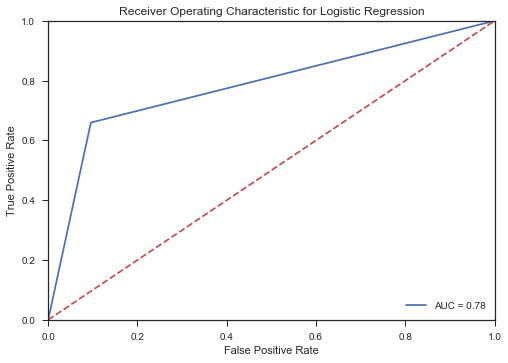

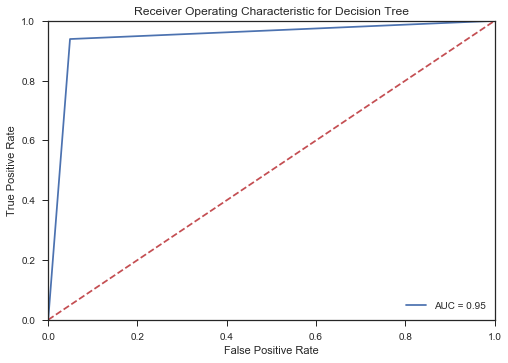

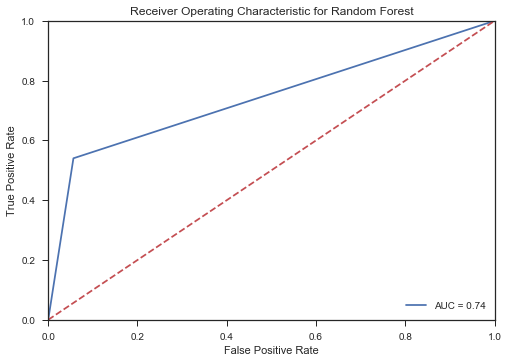

In [65]:
CreateROCCurve(y_test,predictions_lr, 'Logistic Regression')
CreateROCCurve(y_test,predictions_dt, 'Decision Tree')
CreateROCCurve(y_test,predictions_rf, 'Random Forest')